### 11.2 Exercise: Survival Analysis <br> Michael Hotaling <br> 2020-11-13


### Exercise 13-1    
In NSFG Cycles 6 and 7, the variable `cmdivorcx` contains the date of divorce for the respondent’s first marriage, if applicable, encoded in century-months.

Compute the duration of marriages that have ended in divorce, and the duration, so far, of marriages that are ongoing. Estimate the hazard and survival curve for the duration of marriage.

Use resampling to take into account sampling weights, and plot data from several resamples to visualize sampling error.

Consider dividing the respondents into groups by decade of birth, and possibly by age at first marriage.

In [1]:
import nsfg
import survival
import numpy as np
import matplotlib.pyplot as plt
import lifelines
import pandas as pd

In [2]:
resp6 = survival.ReadFemResp2002()
resp7 = survival.ReadFemResp2010()

resp6 = resp6[resp6['evrmarry'] == True]
resp7 = resp7[resp7['evrmarry'] == True]

In [3]:
print(resp6.head())
print(resp7.head())

    caseid  cmbirth  evrmarry  cmmarrhx  cmdivorcx  parity     finalwgt  \
1     5012      718      True     974.0     1077.0       1  4744.191350   
2    11586      708      True     910.0      938.0       1  4744.191350   
5      845      727      True     937.0        NaN       6  4705.681352   
8     8656      780      True    1003.0        NaN       3  6520.021223   
10    5917      714      True     953.0        NaN       2  3488.586646   

    cmintvw   agemarry        age  year  decade  fives  
1      1233  21.333333  42.916667    59       5     11  
2      1234  16.833333  43.833333    58       5     11  
5      1234  17.500000  42.250000    60       6     12  
8      1237  18.583333  38.083333    64       6     12  
10     1233  19.916667  43.250000    59       5     11  
    caseid  cmbirth  evrmarry  cmmarrhx  cmdivorcx  parity      wgtq1q16  \
1    40081      925      True    1314.0        NaN       0  11716.317848   
18   33303      773      True    1076.0        NaN     

The data needs to be cleaned up quite a bit since we have a lot of NA values. We will also need to engineer some attributes like whether or not the data points are divorced, the duration of the marriage, and the duration of the marriage so far.

First, we can remove some of these large values. Not sure what they are, but they need to go

In [4]:
resp6['cmdivorcx'].value_counts(dropna=False).sort_index()

909.0        1
913.0        1
915.0        1
916.0        1
918.0        2
          ... 
1236.0       1
1237.0       1
9998.0       2
9999.0      20
NaN       3122
Name: cmdivorcx, Length: 280, dtype: int64

In [5]:
resp7['cmdivorcx'].value_counts(dropna=False).sort_index()

960.0        1
966.0        1
982.0        1
984.0        1
990.0        3
          ... 
1324.0       1
1325.0       1
9998.0       1
9999.0      19
NaN       3960
Name: cmdivorcx, Length: 305, dtype: int64

In [6]:
resp6['cmdivorcx'].replace([9999,9998], np.nan, inplace=True)
resp7['cmdivorcx'].replace([9999,9998], np.nan, inplace=True)

In [7]:
resp6['cmdivorcx'].value_counts(dropna=False).sort_index()

909.0        1
913.0        1
915.0        1
916.0        1
918.0        2
          ... 
1234.0       4
1235.0       3
1236.0       1
1237.0       1
NaN       3144
Name: cmdivorcx, Length: 278, dtype: int64

In [8]:
resp7['cmdivorcx'].value_counts(dropna=False).sort_index()

960.0        1
966.0        1
982.0        1
984.0        1
990.0        3
          ... 
1321.0       1
1322.0       1
1324.0       1
1325.0       1
NaN       3980
Name: cmdivorcx, Length: 303, dtype: int64

Next, we will engineer some attributes for our calculations

In [39]:
resp6['notdivorced'] = resp6['cmdivorcx'].isnull().astype(int)
resp6['duration'] = (resp6['cmdivorcx'] - resp6['cmmarrhx']) / 12.0
resp6['durationsofar'] = (resp6['cmintvw'] - resp6['cmmarrhx']) / 12.0
  
resp6.head()

,caseid,cmbirth,evrmarry,cmmarrhx,cmdivorcx,parity,finalwgt,cmintvw,agemarry,age,year,decade,fives,notdivorced,duration,durationsofar
1,5012,718,True,974.0,1077.0,1,4744.191350,1233,21.333333,42.916667,59,5,11,0,8.583333,21.583333
2,11586,708,True,910.0,938.0,1,4744.191350,1234,16.833333,43.833333,58,5,11,0,2.333333,27.000000
5,845,727,True,937.0,NaN,6,4705.681352,1234,17.500000,42.250000,60,6,12,1,NaN,24.750000
8,8656,780,True,1003.0,NaN,3,6520.021223,1237,18.583333,38.083333,64,6,12,1,NaN,19.500000
10,5917,714,True,953.0,NaN,2,3488.586646,1233,19.916667,43.250000,59,5,11,1,NaN,23.333333


In [40]:
resp7['notdivorced'] = resp7['cmdivorcx'].isnull().astype(int)
resp7['duration'] = (resp7['cmdivorcx'] - resp7['cmmarrhx']) / 12.0
resp7['durationsofar'] = (resp7['cmintvw'] - resp7['cmmarrhx']) / 12.0

resp7.head()

,caseid,cmbirth,evrmarry,cmmarrhx,cmdivorcx,parity,wgtq1q16,cmintvw,finalwgt,agemarry,age,year,decade,fives,notdivorced,duration,durationsofar
1,40081,925,True,1314.0,NaN,0,11716.317848,1323,11716.317848,32.416667,33.166667,77,7,15,1,NaN,0.750000
18,33303,773,True,1076.0,NaN,3,6603.626644,1289,6603.626644,25.250000,43.000000,64,6,12,1,NaN,17.750000
19,38594,796,True,1089.0,NaN,4,14915.930053,1325,14915.930053,24.416667,44.083333,66,6,13,1,NaN,19.666667
22,28488,810,True,1126.0,NaN,2,6114.806526,1289,6114.806526,26.333333,39.916667,67,6,13,1,NaN,13.583333
23,37022,866,True,1257.0,NaN,3,7831.375643,1326,7831.375643,32.583333,38.333333,72,7,14,1,NaN,5.750000


We will have to drop some more NA values here.

In [41]:
resp6['durationsofar'].value_counts(dropna=False).sort_index()

0.000000      7
0.083333     20
0.166667      7
0.250000     18
0.333333     12
             ..
28.666667     3
28.916667     1
29.083333     1
29.750000     1
30.083333     1
Name: durationsofar, Length: 345, dtype: int64

In [12]:
resp7['durationsofar'].value_counts(dropna=False).sort_index()

0.000000      8
0.083333     15
0.166667     28
0.250000     34
0.333333     23
             ..
29.083333     1
29.250000     2
29.666667     1
30.916667     1
NaN          16
Name: durationsofar, Length: 341, dtype: int64

In [13]:
resp6 = resp6.dropna(subset=['durationsofar'])
resp7 = resp7.dropna(subset=['durationsofar'])

In [14]:
resp6['durationsofar'].value_counts(dropna=False).sort_index()

0.000000      7
0.083333     20
0.166667      7
0.250000     18
0.333333     12
             ..
28.666667     3
28.916667     1
29.083333     1
29.750000     1
30.083333     1
Name: durationsofar, Length: 345, dtype: int64

In [15]:
resp7['durationsofar'].value_counts(dropna=False).sort_index()

0.000000      8
0.083333     15
0.166667     28
0.250000     34
0.333333     23
             ..
29.000000     1
29.083333     1
29.250000     2
29.666667     1
30.916667     1
Name: durationsofar, Length: 340, dtype: int64

Now we can start the survival curve. I'll be using the KaplanMeierFitter from lifelines

In [30]:
kmf1 = lifelines.KaplanMeierFitter()
kmf2 = lifelines.KaplanMeierFitter()

In [31]:
T1 = resp6['durationsofar']
C1 = resp6['notdivorced']
T2 = resp7['durationsofar']
C2 = resp7['notdivorced']

In [32]:
kmf1.fit(T1,C1);

In [33]:
figsize = (12,8)

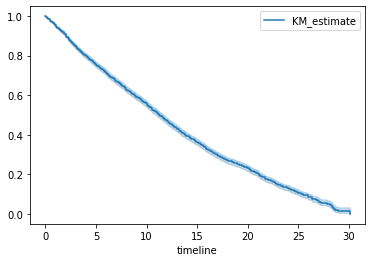

In [34]:
kmf1.plot();

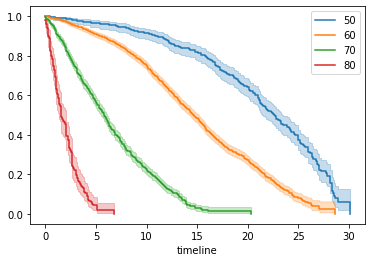

In [35]:
for i in resp6['decade'].unique():
    ix = resp6['decade'] == i
    kmf1.fit(T1[ix], C1[ix], label = str(i * 10))
    kmf1.plot();

In [36]:
kmf2.fit(T2,C2);

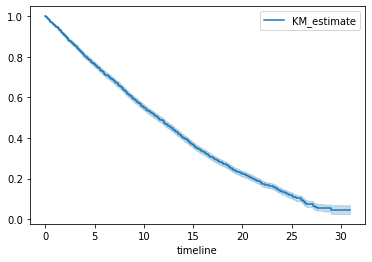

In [37]:
kmf2.plot();

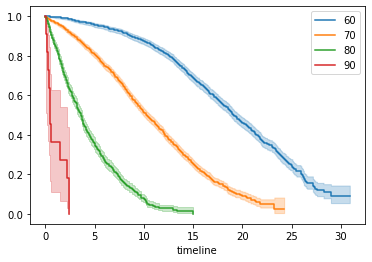

In [47]:
for i in np.sort(resp7['decade'].unique()):
    ix = resp7['decade'] == i
    kmf1.fit(T2[ix], C2[ix], label = str(i * 10))
    kmf1.plot();